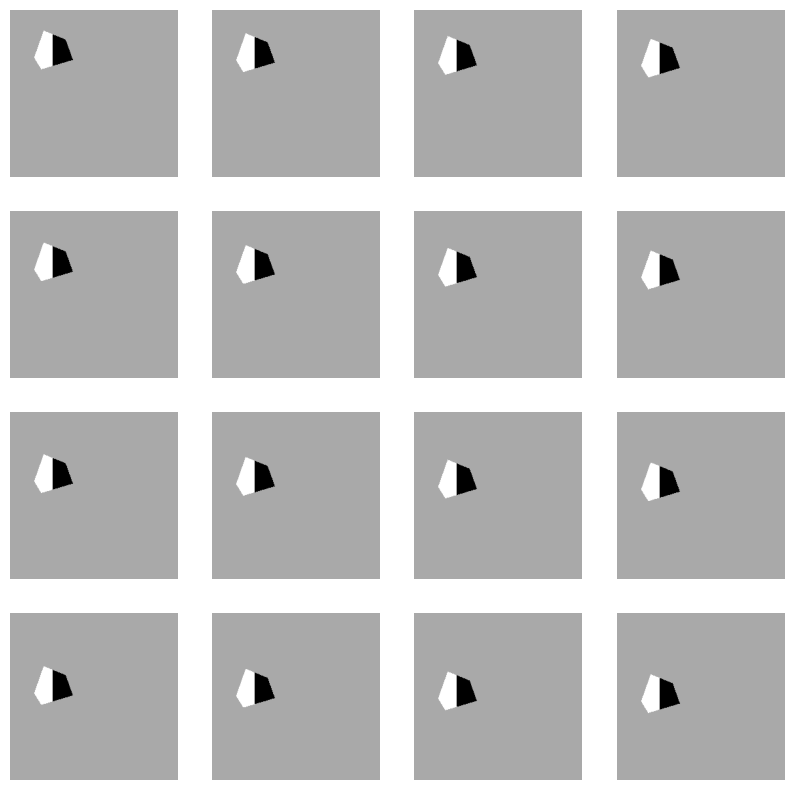

tensor([0.0000, 0.0323, 0.0645, 0.0968, 0.1290, 0.1613, 0.1935, 0.2258, 0.2581,
        0.2903, 0.3226, 0.3548, 0.3871, 0.4194, 0.4516, 0.4839],
       dtype=torch.float64)


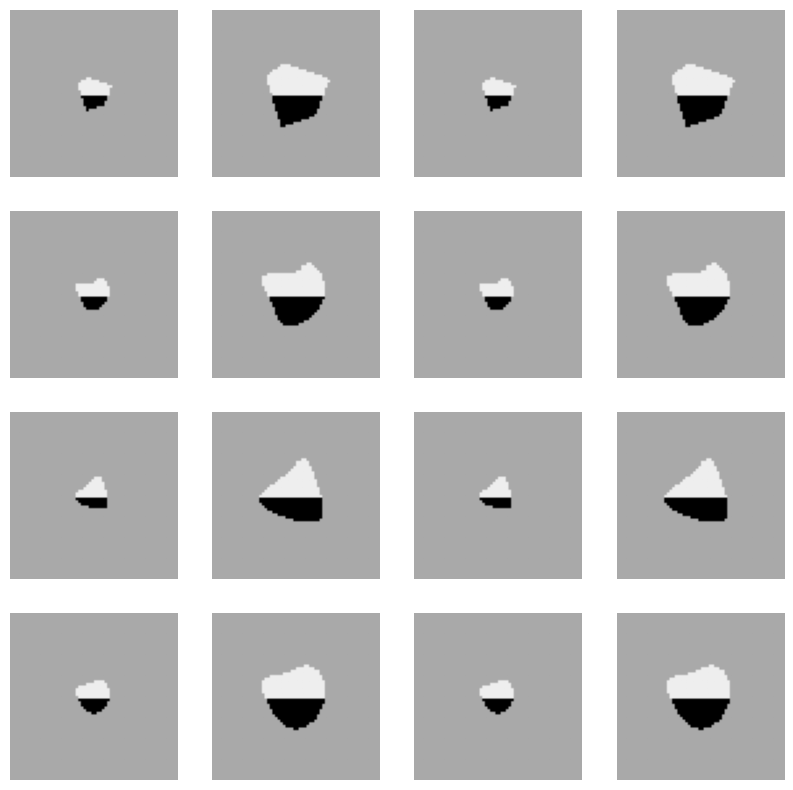

tensor([0.4000, 0.8000, 0.4000, 0.8000, 0.4000, 0.8000, 0.4000, 0.8000, 0.4000,
        0.8000, 0.4000, 0.8000, 0.4000, 0.8000, 0.4000, 0.8000],
       dtype=torch.float64)


In [1]:
from torch.utils.data import DataLoader
import numpy as np

import idsprites as ids
from idsprites.visualization import draw_batch

np.random.seed(0)
dataset = ids.InfiniteDSprites()
dataloader = DataLoader(dataset, batch_size=16)
batch_img, factors = next(iter(dataloader))
img = draw_batch(batch_img, save=False, show=True)
print(factors.position_y)
np.random.seed(0)

generate_shape = ids.InfiniteDSprites().generate_shape
shapes = [generate_shape() for _ in range(4)]
shapes = [shape for shape in shapes for _ in range(2)] # duplicate each shape

dataset = ids.InfiniteDSprites(
    img_size=64,
    color_range=["#EEEEEE"],
    orientation_marker_color="#000000",
    shapes=shapes,
    dataset_size = 10000,
    scale_range = [0.4, 0.8],
    orientation_range= [0.5 * np.pi],
    position_x_range= [0.5],
    position_y_range= [0.5],
    orientation_marker=True,
)
dataloader = DataLoader(dataset, batch_size=16)
batch_img, factors = next(iter(dataloader))
img = draw_batch(batch_img, save=False, show=True)

print(factors.scale)

In [78]:
from tqdm.notebook import tqdm
class FiniteDSprites(ids.InfiniteDSprites):
    def generate_shape_with_verts(self, n_verts) -> npt.NDArray:
        """Generate random vertices and connect them with straight lines or a smooth curve.
        Args:
            None
        Returns:
            An array of shape (2, num_verts).
        """
        verts = self.sample_vertex_positions(min_verts = n_verts, max_verts=n_verts)
        shape = (
            self.interpolate(verts)
            if np.random.rand() < 0.5
            else self.interpolate(verts, k=1)
        )
        shape = self.align(shape)
        shape = self.center_and_scale(shape)
        return shape
    def sample_vertex_positions(
        self,
        min_verts: int = 5,
        max_verts: int = 8,
        radius_std: float = 0.4,
        angle_std: float = 0.5,
    ):
        """Sample the positions of the vertices of a polygon.
        Args:
            min_verts: Minimum number of vertices (inclusive).
            max_verts: Maximum number of vertices (inclusive).
            radius_std: Standard deviation of the polar radius when sampling the vertices.
            angle_std: Standard deviation of the polar angle when sampling the vertices.
        Returns:
            An array of shape (2, num_verts).
        """
        num_verts = np.random.randint(min_verts, max_verts + 1)
        rs = np.random.normal(1.0, radius_std, num_verts)
        rs = np.clip(rs, 0.1, 1.9)

        epsilon = 1e-6
        circle_sector = np.pi / num_verts - epsilon
        intervals = np.linspace(0, 2 * np.pi, num_verts, endpoint=False)
        thetas = np.random.normal(0.0, circle_sector * angle_std, num_verts)
        thetas = np.clip(thetas, -circle_sector, circle_sector) + intervals

        verts = [[r * np.cos(theta), r * np.sin(theta)] for r, theta in zip(rs, thetas)]
        verts = np.array(verts).T
        return verts

class InfiniteDSpritesFactors(ids.InfiniteDSprites):
    """Infinite (iterable) dataset of factors of variation."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        """Generate an infinite stream of factors with shape set to None."""
        while True:
            if self.shapes is not None and self.current_shape_index >= len(self.shapes):
                return
            for color, scale, orientation, position_x, position_y in product(
                *self.ranges.values()
            ):
                if self.dataset_size is not None and self.counter >= self.dataset_size:
                    return
                self.counter += 1
                color = np.array(colors.to_rgb(color))
                yield Factors(
                    shape=None,
                    color=color,
                    shape_id=self.current_shape_id,
                    scale=scale,
                    orientation=orientation,
                    position_x=position_x,
                    position_y=position_y,
                )
            self.current_shape_index += 1



class InfiniteDSpritesMap(Dataset):
    """Finite (map-style) dataset of shapes undergoing transformations."""

    def __init__(self, *args, **kwargs):
        self.dataset = InfiniteDSpritesFactors(*args, **kwargs)
        assert (
            self.dataset.dataset_size is not None or self.dataset.shapes is not None
        ), "Dataset size must be finite. Please set dataset_size or pass a list of shapes."
        self.data = list(self.dataset)
        self.y_transform = kwargs.get("y_transform", lambda y: y)
        self.x_transform = kwargs.get("x_transform", lambda x: x)

    @property
    def targets(self):
        return [factors.shape_id for factors in self.data]

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        shape_index = self.data[index].shape_id
        if self.dataset.shape_ids is not None:
            shape_index = self.dataset.shape_ids.index(shape_index)
        shape = self.dataset.shapes[shape_index]
        factors = self.data[index].replace(shape=shape)
        img = self.x_transform(self.dataset.draw(factors))
        factors = self.y_transform(factors)
        return img, factors
generate_shape = FiniteDSprites().generate_shape_with_verts

sample_vertex = FiniteDSprites().sample_vertex_positions

In [84]:
from itertools import product
for i, (color, scale, orientation, position_x, position_y) in enumerate(product(
                *ds.dataset.ranges.values()
            )):
    print(i)

0
1


In [68]:
sample_vertex(min_verts=3, max_verts=3)

array([[ 1.41310929, -0.55736169, -0.27432395],
       [-0.70340498,  1.06763025, -0.72853536]])

In [86]:
product(ds.dataset.ranges.values())

In [87]:
ds.dataset.ranges.values()

dict_values([['#EEEEEE'], [0.4, 0.8], [1.5707963267948966], [0.5], [0.5]])

In [73]:
ds = InfiniteDSpritesMap(
    img_size=64,
    color_range=["#EEEEEE"],
    orientation_marker_color="#000000",
    shapes=shapes,
    shape_ids=shape_ids,
    #dataset_size = 10000,
    scale_range = [0.4, 0.8],
    orientation_range= [0.5 * np.pi],
    position_x_range= [0.5],
    position_y_range= [0.5],)

In [ ]:

n_samples_per_shape = 10000
shape_ids = []
shapes = []
for n_verts in tqdm(range(3,11)): # InDistribution Shapes
    shapes.append(generate_shape(n_verts))
    shape_ids.append(n_verts)
    

ds = ids.InfiniteDSpritesMap(
    img_size=64,
    color_range=["#EEEEEE"],
    orientation_marker_color="#000000",
    shapes=shapes,
    shape_ids=shape_ids,
    #dataset_size = 10000,
    scale_range = [0.4, 0.8],
    orientation_range= [0.5 * np.pi],
    position_x_range= [0, 0.5],
    position_y_range= [0.5],)

In [ ]:
shape, scale, orientation, x, y

In [89]:
5**4

625

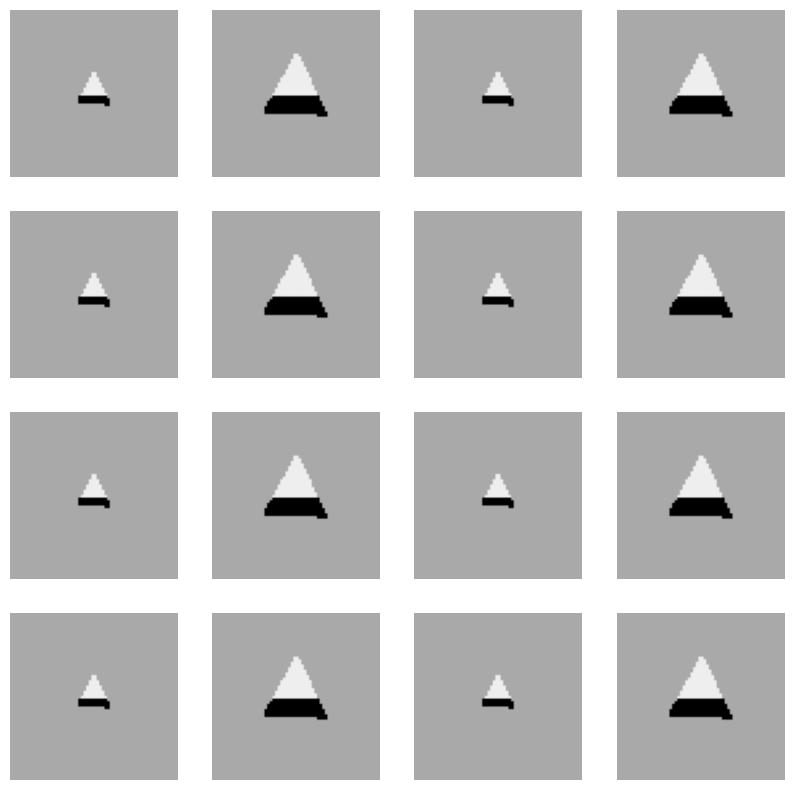

tensor([[[ 0.3524,  0.3523,  0.3522,  ...,  0.3444,  0.3484,  0.3524],
         [-0.4828, -0.4807, -0.4785,  ..., -0.4791, -0.4810, -0.4828]],

        [[ 0.3524,  0.3523,  0.3522,  ...,  0.3444,  0.3484,  0.3524],
         [-0.4828, -0.4807, -0.4785,  ..., -0.4791, -0.4810, -0.4828]],

        [[ 0.3524,  0.3523,  0.3522,  ...,  0.3444,  0.3484,  0.3524],
         [-0.4828, -0.4807, -0.4785,  ..., -0.4791, -0.4810, -0.4828]],

        ...,

        [[ 0.3524,  0.3523,  0.3522,  ...,  0.3444,  0.3484,  0.3524],
         [-0.4828, -0.4807, -0.4785,  ..., -0.4791, -0.4810, -0.4828]],

        [[ 0.3524,  0.3523,  0.3522,  ...,  0.3444,  0.3484,  0.3524],
         [-0.4828, -0.4807, -0.4785,  ..., -0.4791, -0.4810, -0.4828]],

        [[ 0.3524,  0.3523,  0.3522,  ...,  0.3444,  0.3484,  0.3524],
         [-0.4828, -0.4807, -0.4785,  ..., -0.4791, -0.4810, -0.4828]]],
       dtype=torch.float64)
tensor([[0.9333, 0.9333, 0.9333],
        [0.9333, 0.9333, 0.9333],
        [0.9333, 0.9333, 0

In [59]:
dataloader = DataLoader(ds, batch_size=16)
batch_img, factors = next(iter(dataloader))
img = draw_batch(batch_img, save=False, show=True)
for f in factors:
    print(f)

In [60]:
sample_vertex = FiniteDSprites().sample_vertex_positions

sample_vertex(min_verts=3,max_verts=3)

In [37]:
len(ds)

10000

In [16]:
ds[0][1]['shape']

array([[-0.2139258 , -0.21024605, -0.2065663 , ..., -0.21559859,
        -0.21476219, -0.2139258 ],
       [-0.52614991, -0.52463505, -0.52312019, ..., -0.52139958,
        -0.52377475, -0.52614991]])

## Create Dataset

In [143]:

shape_ids = []
shapes = []
for n_verts in tqdm(range(3,13)): #  Shapes OOD = (3,4,11,12), ID= {5..10} # 10 total shapes
    shapes.append(generate_shape(n_verts))
    shape_ids.append(n_verts - 3)
scale = np.linspace(0.5, 1.0, 14)
orientation = np.linspace(0, 2 * np.pi * 32 / 33, 14)
x = np.linspace(0, 1, 14)
y = np.linspace(0, 1, 14)

shapes = {'id': shapes[2:-2], 'ood': shapes[:2]+ shapes[-2:]}
shape_ids = {'id': shape_ids[2:-2], 'ood': np.squeeze([shape_ids[:2]+shape_ids[-2:]])}
scale = {'id': scale[2:-2], 'ood': np.concatenate([scale[:2], scale[-2:]])}
orientation = {'id': orientation[2:-2], 'ood': np.concatenate([orientation[:2], orientation[-2:]])}
x = {'id': x[2:-2], 'ood': np.concatenate([x[:2], x[-2:]])}
y = {'id': y[2:-2], 'ood': np.concatenate([y[:2], y[-2:]])}
# Create id train set

ds = dict()
for attribute in ['train', 'shape', 'scale', 'orientation', 'x', 'y']:
    print(attribute)
    ds[attribute] = ids.InfiniteDSpritesMap(
        img_size=64,
        orientation_marker_color="#000000",
        shapes=shapes['id' if attribute != 'shape' else 'ood'],
        shape_ids=shape_ids['id'] if attribute != 'shape' else None,
        scale_range = scale['id' if attribute != 'scale' else 'ood'],
        orientation_range= orientation['id' if attribute != 'orientation' else 'ood'],
        position_x_range= x['id' if attribute != 'x' else 'ood'],
        position_y_range= y['id' if attribute != 'y' else 'ood']
)


  0%|          | 0/10 [00:00<?, ?it/s]

train
shape
scale
orientation
x
y


In [155]:
import numpy as np
for attribute in tqdm(["train", "shape",'scale', 'orientation', 'x', 'y']):
    print(attribute)
    dl = DataLoader(ds[attribute], batch_size=128, shuffle=False)
    images = []
    latents = []
    for imgs, factors in tqdm(dl):
        images.append(imgs)
        if attribute == "shape":
            ss = factors.shape_id
            ss = list(ss)
            ss = [shape_ids['ood'][s.item()] for s in ss]
            ss = torch.tensor(ss)
            
        else:
            ss = factors.shape_id

        latent = torch.cat((ss.unsqueeze(-1), 
                       factors.scale.unsqueeze(-1),
                       factors.orientation.unsqueeze(-1),
                       factors.position_x.unsqueeze(-1),
                       factors.position_y.unsqueeze(-1)),
                      dim=1)
        latents.append(latent)
    images = torch.cat(images, dim=0)
    latents = torch.cat(latents, dim=0)
    # Save files!
    np.savez(f"idsprites_images_{attribute}.npz", images.numpy())
    np.savez(f"idsprites_latents_{attribute}.npz", latents.numpy())

  0%|          | 0/6 [00:00<?, ?it/s]

train


  0%|          | 0/469 [00:00<?, ?it/s]

shape


  0%|          | 0/313 [00:00<?, ?it/s]

scale


  0%|          | 0/188 [00:00<?, ?it/s]

orientation


  0%|          | 0/188 [00:00<?, ?it/s]

x


  0%|          | 0/188 [00:00<?, ?it/s]

y


  0%|          | 0/188 [00:00<?, ?it/s]

In [1]:
!ls

3dShapes.ipynb				idsprites_images_x.npz
3dShapesAbstraction.ipynb		idsprites_images_y.npz
3dShapes_Baseline_Results.ipynb		idsprites_latents_orientation.npz
3dShapes_Sample.ipynb			idsprites_latents_scale.npz
3dshapes_loading_example.ipynb		idsprites_latents_shape.npz
EncoderTraining.ipynb			idsprites_latents_train.npz
InfiniteDSprites.ipynb			idsprites_latents_x.npz
Representation_Prediction_Latent.ipynb	idsprites_latents_y.npz
Shapes_3d_Baseline.ipynb		jupyter.err
Shapes_3d_Lightning_Baseline.ipynb	jupyter.out
Subsample_dataset.ipynb			lightning_logs
Tinca_tinca_Prague_Vltava_2.jpg		lightning_models.py
White_shark.jpg				models
__pycache__				models.py
datasets.py				optim.py
encoder_erm_baseline.sh			pair_erm_baseline.sh
encoder_erm_pretrained.sh		results
encoder_erm_untrained_baseline.sh	run_expt.py
erm_base_13107.err			speed_test.sh
erm_baseline.sh				task_jepa_rep_training.sh
exp_logs				train.py
extract_features.py			train_encoder.py
idsprites_images_orientation.npz	train_light

In [ ]:
from torch.utils.data import Dataset
class IdSprites(Dataset):
    def __init__(self, root_dir="", split="train"):
        self.__super__()
        img_path = join(root_dir, f"id_s{}"
        images = np.load(img_path)['arr_0']
        latents = np.load(latents_path)['arr_0']